In [ ]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Layer
from tensorflow.keras.layers import Input, Conv2D, Dense, Add, Concatenate, Reshape, AveragePooling2D, Dropout, Lambda, UpSampling2D, BatchNormalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
from tensorflow.keras.saving import register_keras_serializable

mixed_precision.set_global_policy("float32")

In [ ]:
#___ GOOGLE DRIVE DATA LOADING ___
#from google.colab import drive
#drive.mount('/content/drive')

# Set your dataset path
#path = '/content/drive/MyDrive/cat'

Mounted at /content/drive


In [ ]:
img_size = (64,64,3)
embedding_dim = 512
filters = [32, 64, 96, 128]
T = 500
a = np.linspace(0.00001, 0.02, T)
embedding_max_frequency = tf.constant(1000.0, dtype=tf.float32)

In [ ]:
def normalise_img(img_tensor): # Maps [-1,1] to [0,1]
    img = img_tensor.copy()
    img *= 0.5
    img += 0.5
    return img

def expand_img(img_tensor): # Maps [0,1] to [-1,1]
    img = img_tensor.copy()
    img *= 2
    img -= 1
    return img

def noisify_img(img_tensor, t): # Returns Epsilon, X_t (in [-1,1] form)
    epsilon = np.random.normal(0, 0.3, img_tensor.shape)
    img = img_tensor.copy()
    img = ((1 - a[t])**0.5) * img + (a[t]**0.5) * epsilon
    return img, epsilon

def denoisify_img(img_tensor, epsilon, t): # X_t-1 (in [-1,1] form)
    img = img_tensor.copy()
    img = (img - (epsilon * (a[t])**0.5)) / (1 - a[t])**0.5
    return img

@register_keras_serializable()
def sinusoidal_embedding(x, embedding_dim=embedding_dim):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dim // 2,
        )
    )
    angular_speeds = tf.cast(2.0 * np.pi * frequencies, "float32")

    x = tf.reshape(x, (-1, 1, 1, 1))

    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=-1
    )
    return embeddings

def ResidualBlock(filters):
    def call(x):
        if filters == x.shape[3]:
            resid = x
        else:
            resid = Conv2D(filters, kernel_size=1)(x)
        x = BatchNormalization(center=False, scale=False)(x)
        x = Conv2D(filters, kernel_size=3, padding="same", activation="swish")(x)
        x = Conv2D(filters, kernel_size=3, padding="same")(x)
        x = Add()([x, resid])
        return x
    return call

def DownBlock(filters, depth):
    def call(x):
        x, cache = x
        for _ in range(depth):
            x = ResidualBlock(filters)(x)
            cache.append(x)
        x = AveragePooling2D(pool_size=2)(x)
        return x
    return call

def UpBlock(filters, depth):
    def call(x):
        x,cache = x
        x = UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(depth):
            x = Concatenate()([x, cache.pop()])
            x = ResidualBlock(filters)(x)
        return x
    return call

In [ ]:
reload_data = True
num_imgs = 400

In [ ]:
#IF DATA ALREADY LOADED DONT DO IT AGAIN!!!
#if reload_data:
#    path = r"/content/drive/MyDrive/cat"
#    img_tensors = []
#    for root, _, files in os.walk(path):
#        for file in files:
#            if file.endswith(".jpg"):
#                image_path = os.path.join(root, file)
#                img = Image.open(image_path).resize((64,64))
#                img = np.array(img).astype(np.float32) / 127.5 - 1.0
#                img_tensors.append(normalise_img(img))
#    img_tensors = np.array(img_tensors)

In [ ]:
def create_model(filters, image_size=64, block_depth=2):
    input_img = Input(shape=(image_size, image_size, 3))
    input_var = Input(shape=(1, 1, 1))
    emb = Lambda(sinusoidal_embedding, output_shape=(1, 1, embedding_dim))(input_var)
    emb = UpSampling2D(size=image_size, interpolation="nearest")(emb)

    x = Conv2D(filters[0], kernel_size=1)(input_img)
    x = Concatenate()([x, emb])

    cache = []
    for f in filters[:-1]:
        x = DownBlock(f, block_depth)([x,cache])

    for _ in range(block_depth):
        x = ResidualBlock(filters[-1])(x)

    for f in reversed(filters[:-1]):
        x = UpBlock(f, block_depth)([x, cache])

    x = Conv2D(3, kernel_size=3, padding="same", activation="tanh")(x)
    return Model([input_img, input_var], x, name="lexnet")

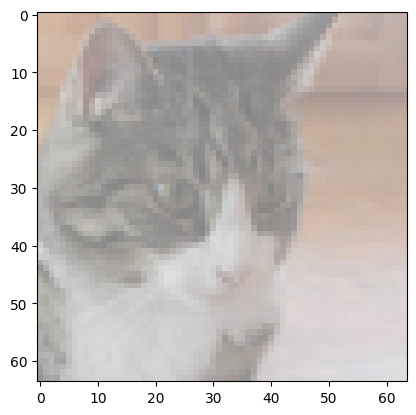

In [ ]:
plt.imshow(normalise_img(img_tensors[94]))
#Example target img below

In [ ]:
class DiffusionDataGen(tf.keras.utils.Sequence):
    def __init__(self, img_tensors, a, batch_size=64, T=500, shuffle=True):
        super().__init__()  # THIS IS IMPORTANT
        self.imgs = img_tensors
        self.a = a
        self.batch_size = batch_size
        self.T = T
        self.shuffle = shuffle

        self.indices = np.arange(len(img_tensors) * T)
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]

        X_img = []
        X_var = []
        Y = []

        for bi in batch_indices:
            i = bi // self.T
            t = bi % self.T
            x = self.imgs[i]
            x = expand_img(x)
            x_t, eps = noisify_img(x, t)
            X_img.append(x_t)
            X_var.append(self.a[t] / (1 - self.a[t]))
            Y.append(eps)

        X_img = np.array(X_img, dtype=np.float32)
        X_var = np.array(X_var, dtype=np.float32).reshape(-1, 1, 1, 1)
        Y = np.array(Y, dtype=np.float32)

        return (X_img, X_var), Y  # Return a tuple, not a list

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [ ]:
train_gen = DiffusionDataGen(img_tensors, a, batch_size=64, T=500)

model = create_model(filters)
model.compile(optimizer='adam', loss='mse')

model.fit(train_gen, epochs=10)

Epoch 1/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 781s 233ms/step - loss: 0.2568
Epoch 2/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 757s 234ms/step - loss: 0.0361
Epoch 3/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 757s 233ms/step - loss: 0.0315
Epoch 4/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 758s 234ms/step - loss: 0.0291
Epoch 5/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 758s 234ms/step - loss: 0.0277
Epoch 6/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 758s 234ms/step - loss: 0.0267
Epoch 7/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 758s 234ms/step - loss: 0.0261
Epoch 8/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 758s 234ms/step - loss: 0.0255
Epoch 9/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 758s 234ms/step - loss: 0.0251
Epoch 10/10
3242/3242 ━━━━━━━━━━━━━━━━━━━━ 758s 234ms/step - loss: 0.0249


In [ ]:
#model.save('/content/drive/MyDrive/lexnet_v1.h5')

In [ ]:
imgs = []
for i in range(10):
  noise = np.random.normal(0, 0.4, (64,64,3))
  img = noise.copy()
  for i in range(1,T):
    t = T-i
    t_input = np.full((1, 1, 1), a[t] / (1 - a[t]), dtype=np.float32)
    epsilon = model.predict([np.array([img]), np.array([t_input])],verbose=0)[0]
    img = denoisify_img(img, epsilon, t)
    imgs.append(img)

NameError: name 'np' is not defined

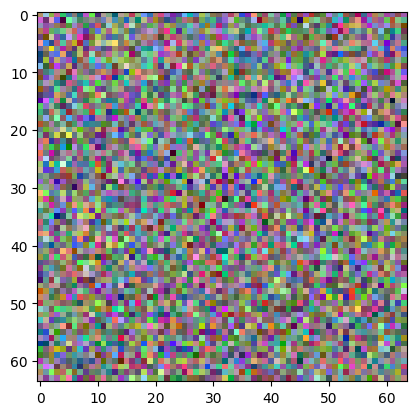

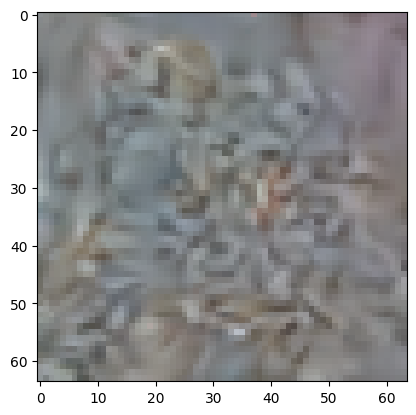

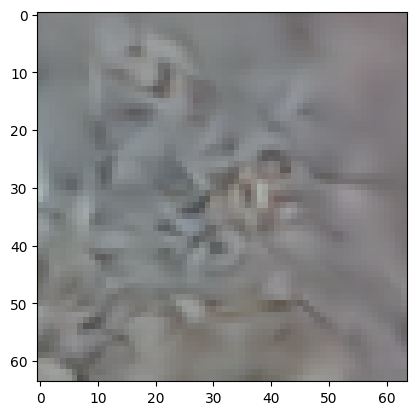

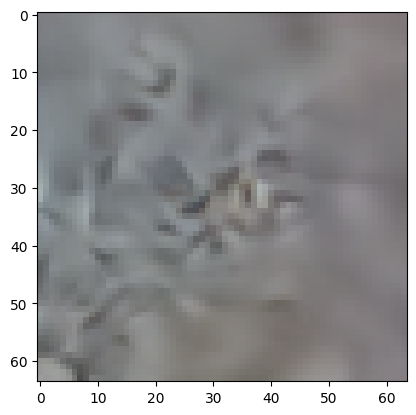

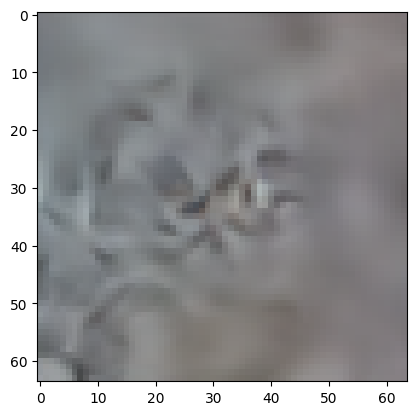

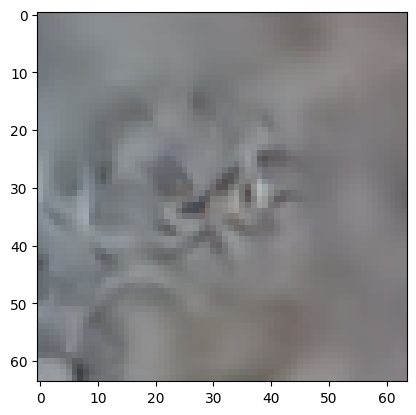

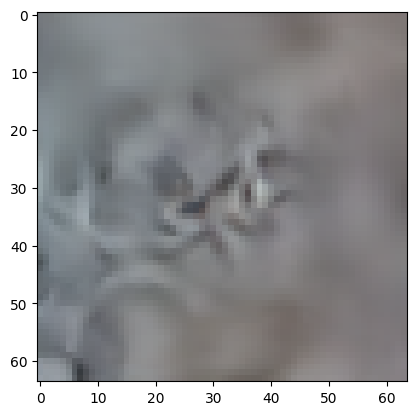

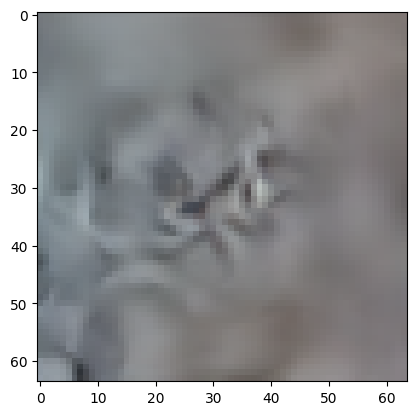

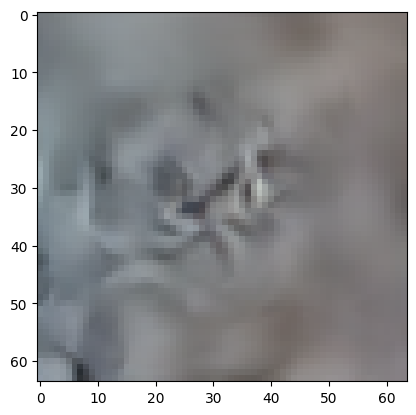

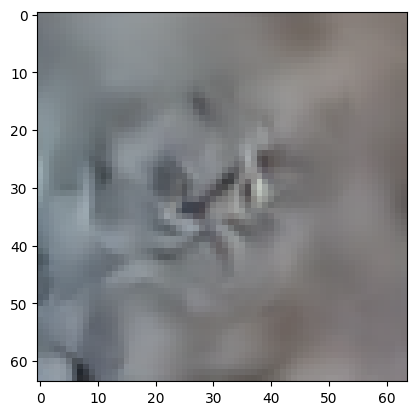

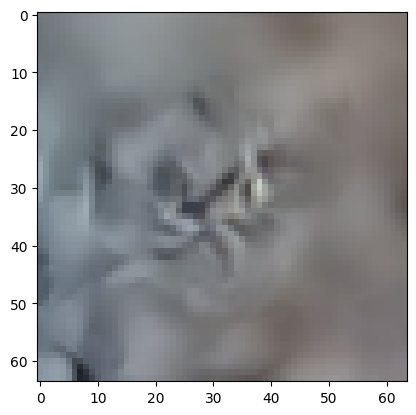

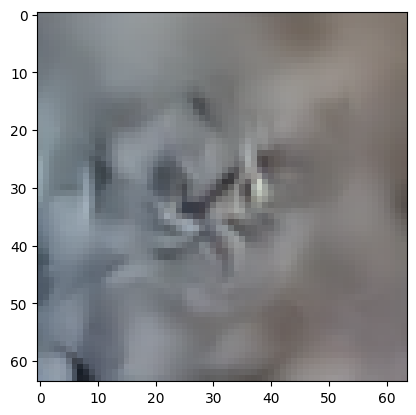

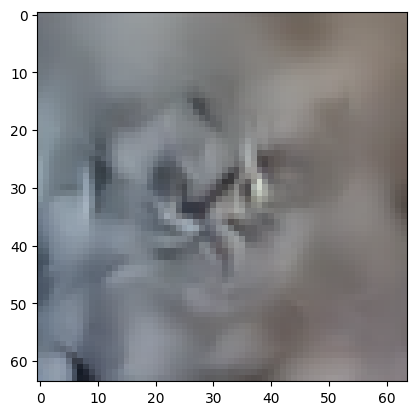

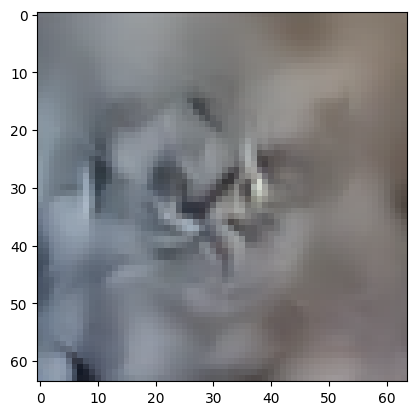

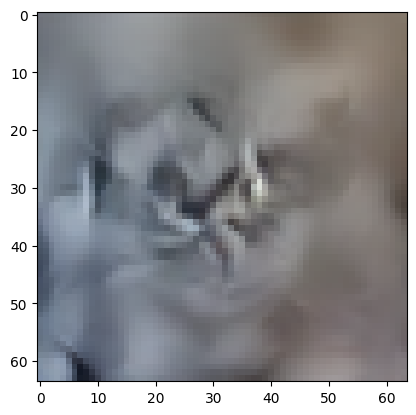

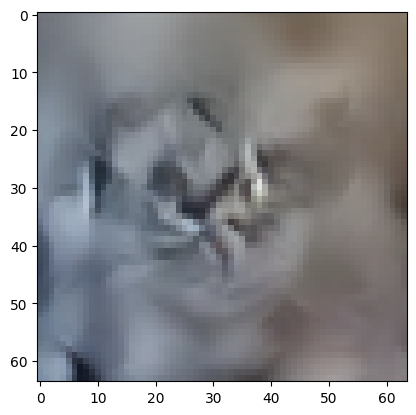

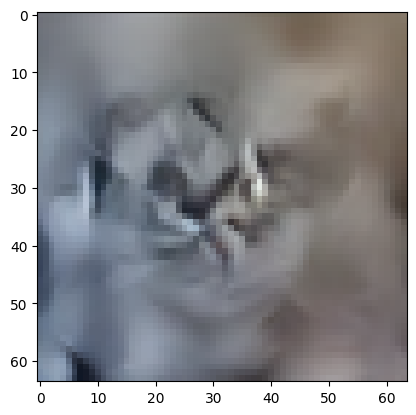

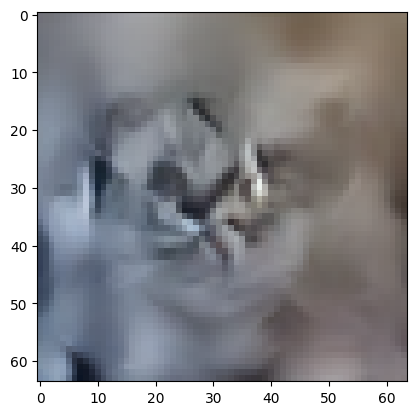

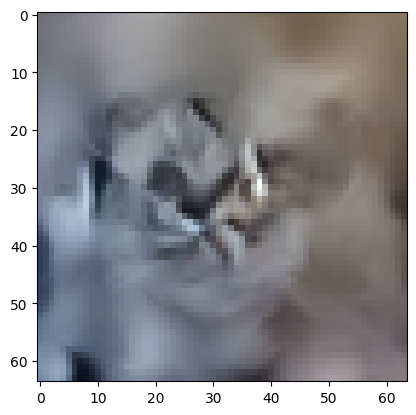

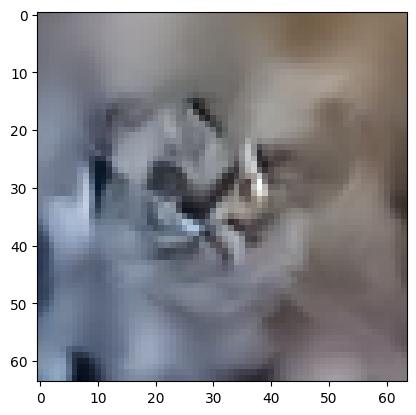

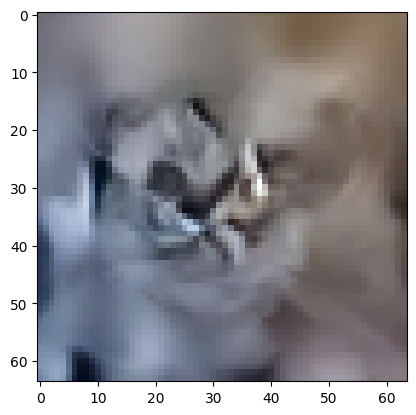

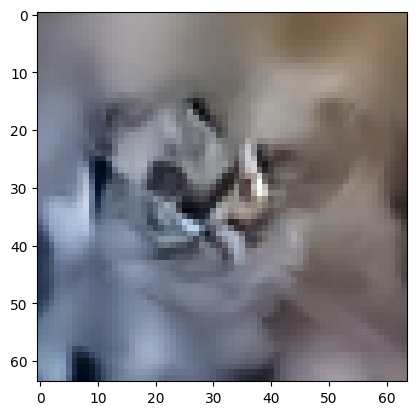

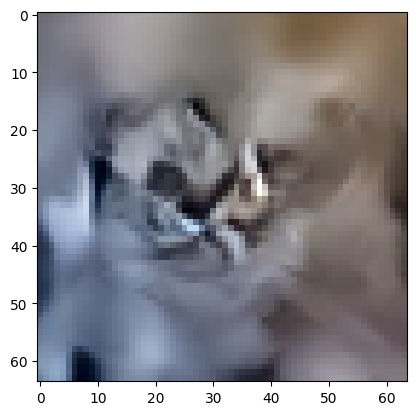

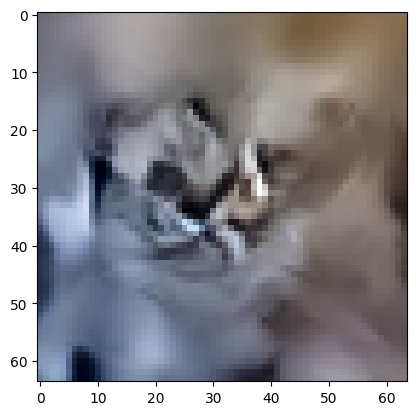

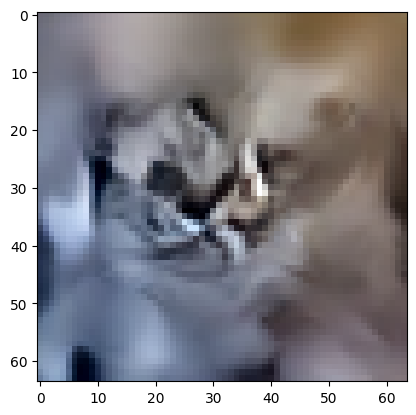

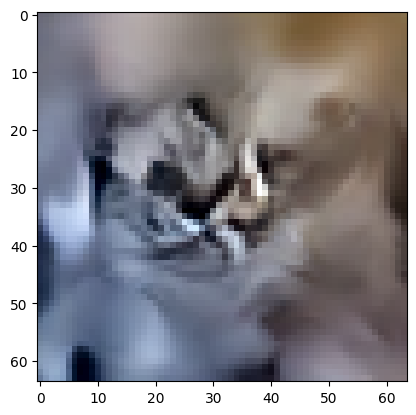

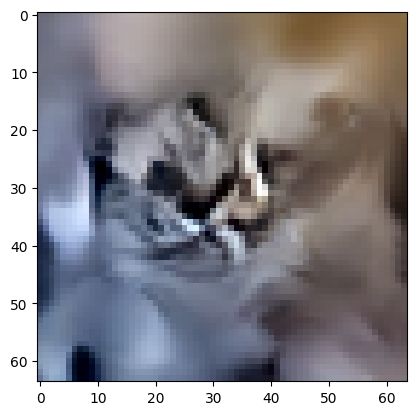

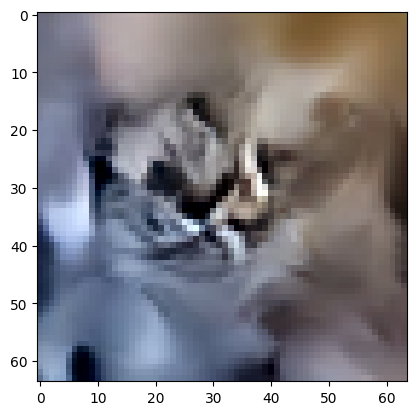

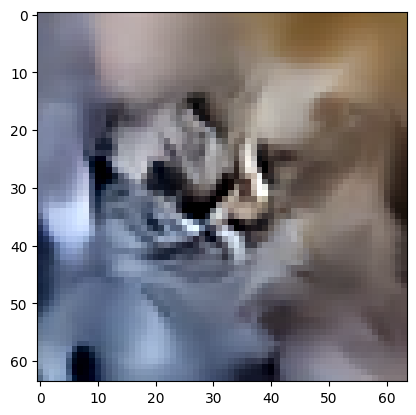

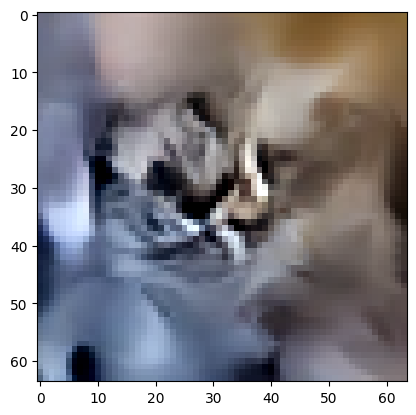

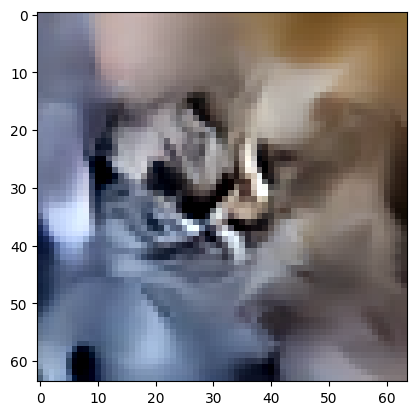

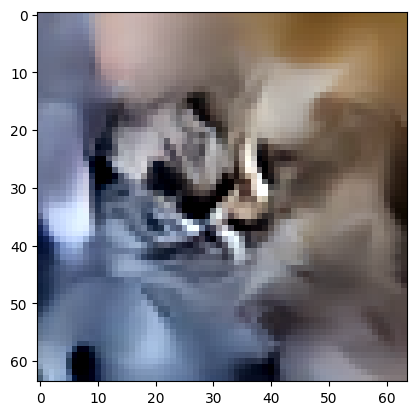

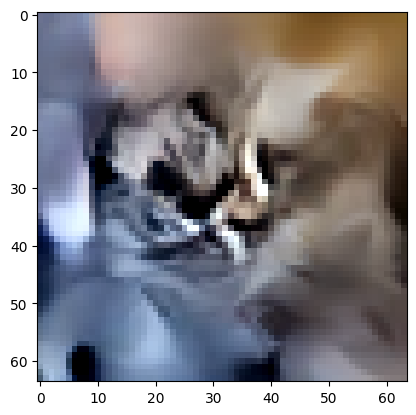

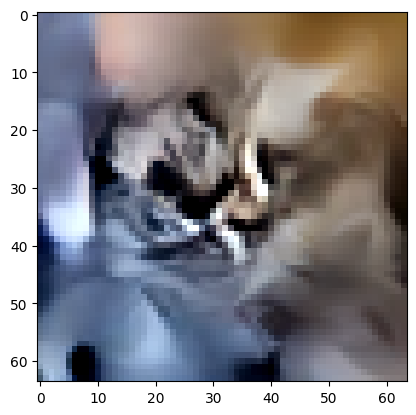

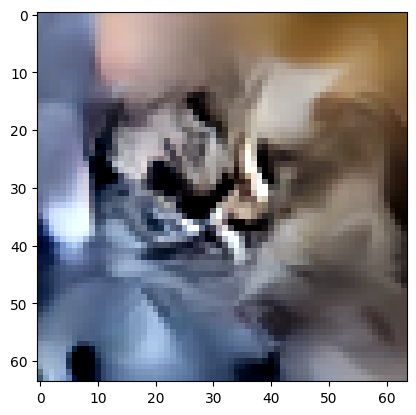

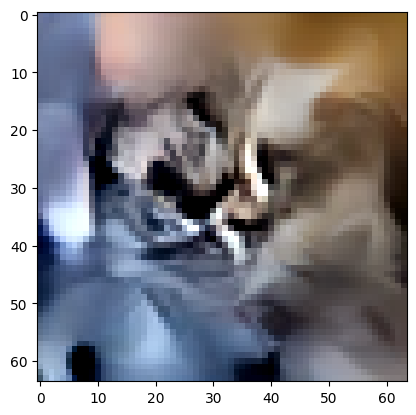

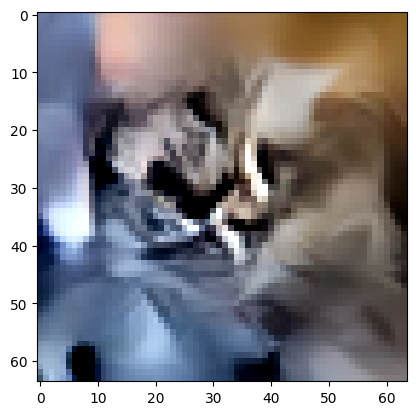

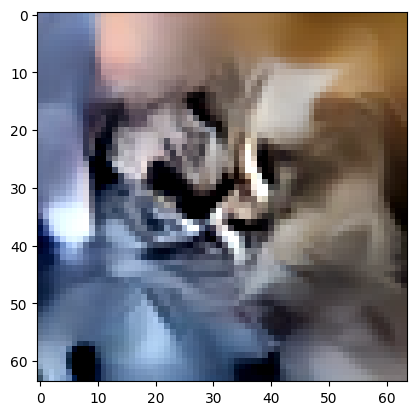

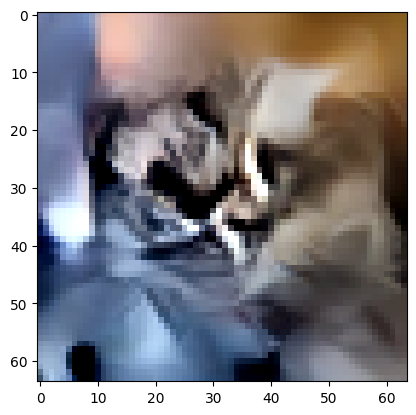

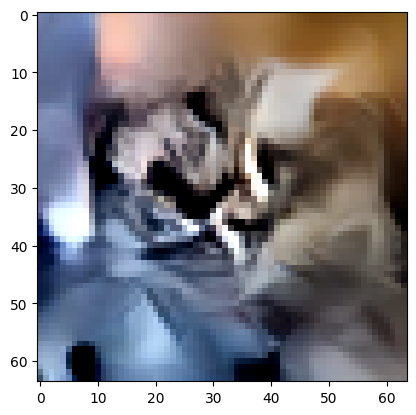

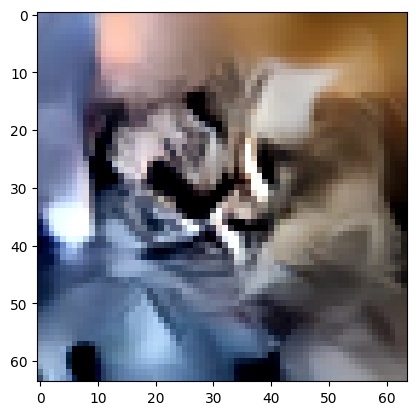

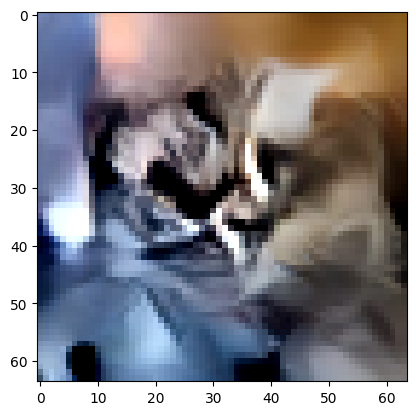

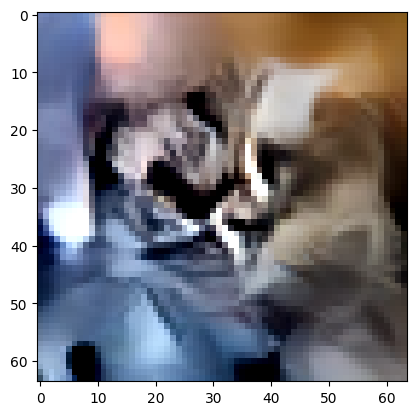

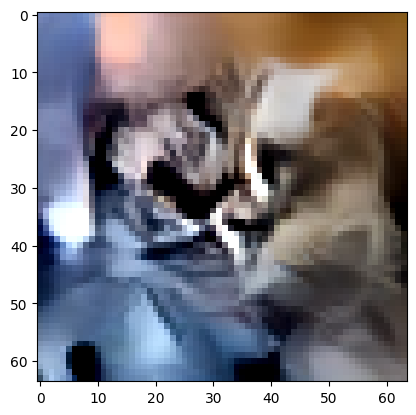

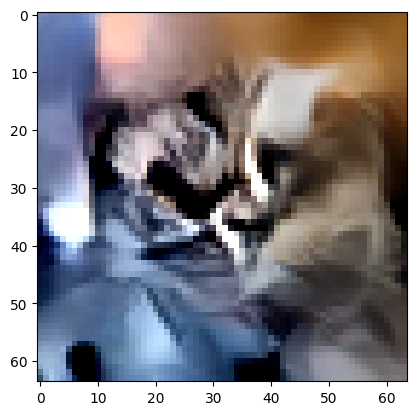

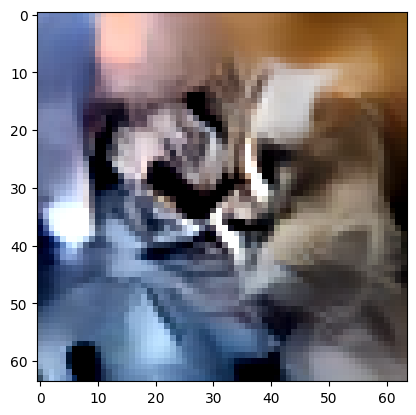

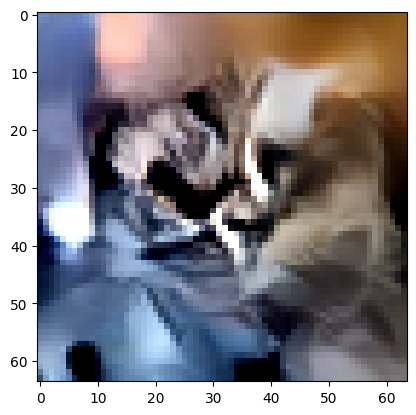

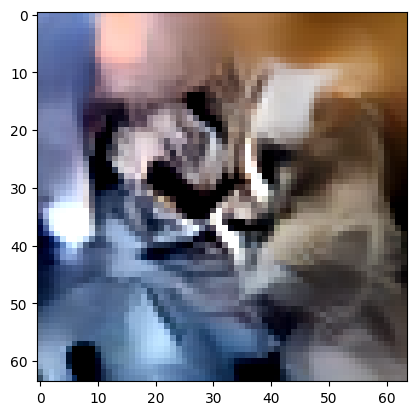

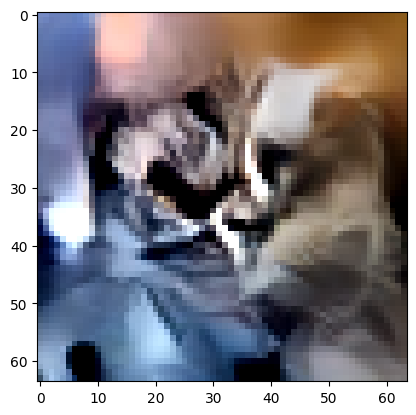

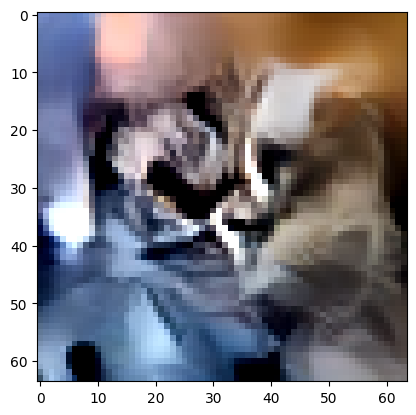

In [ ]:
for img in imgs:
  plt.imshow(normalise_img(img))
  plt.show()
#Example full diffusion timeline below